# Vaccinatie-/Misinformatie-Classifier
## ...

(hier komt wat uitleg waar dit over gaat en wat het is).


In [1]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from math import log, sqrt
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pk
import numpy as np
import glob
import os
from collections import Counter
from pandas import DataFrame, read_csv
import matplotlib.pyplot as plt
from stop_words import get_stop_words
from string import punctuation
import eli5

STOPWORDS = get_stop_words('dutch')

### 1. Define functions for preprocessing and data retrieval

In [2]:
def preprocess(doc):
    if type(doc) is str:
        doc = doc.lower()
        doc = doc.translate(str.maketrans({key: " " for key in string.punctuation}))
        doc = " ".join([w for w in doc.split() if w not in STOPWORDS])
        return doc
    else:
        print('Received non-string input, returning empty string')
        return ''

In [3]:
def get_traintest(df, test_size=.30):
    '''takes dataframe, selects relevant part, preprocesses text and returns train, test data lists with 
    (text, label) tuples'''
    rows = df[['Platte tekst (zonder opmaak)','Misinfo Nee(1) Ja(0)']].dropna().to_records(index=False)
    rowsclean = []
    for e in rows:
        try:
            rowsclean.append((preprocess(e[0]), abs(int(e[1])-1)))  # we now code misinfo as 1 and legitimate as 0
        except ValueError:
            pass
    if test_size < 1:
        train, test = train_test_split(rowsclean, test_size=test_size)
        return train, test
    if test_size == 1:
        return [], rowsclean


### 2. Read data

We have two datasets: one on childhood vaccination on which we train and test, and one on HPV that we use for testing out-of-sample prediction only

In [4]:
hpv = pd.read_csv('hpv.csv')
childhood = pd.read_csv('childhood.csv')

In [5]:
childhood_train, childhood_test = get_traintest(childhood)
print("Obtained {} train and {} test tuples for childhood vaccination".format(len(childhood_train), len(childhood_test)))

hpv_train, hpv_test = get_traintest(hpv, test_size=1)
print("Obtained {} train and {} test tuples for HPV".format(len(hpv_train), len(hpv_test)))

Obtained 316 train and 136 test tuples for childhood vaccination
Obtained 0 train and 198 test tuples for HPV


### 3. Define Machine Learning-functions

In [6]:
def performance(predictions, actual_scores):
    accuracy=metrics.accuracy_score(actual_scores,predictions,normalize=True)
    recall_misinfo=metrics.recall_score(actual_scores,predictions,pos_label=1)
    recall_legitimate=metrics.recall_score(actual_scores,predictions,pos_label=0)
    precision_misinfo=metrics.precision_score(actual_scores,predictions,pos_label=1)
    precision_legitimate=metrics.precision_score(actual_scores,predictions,pos_label=0)
    confusionmatrix=metrics.confusion_matrix(actual_scores,predictions)
    print('Accuracy:',accuracy,
          '\nRecall (misinfo):',recall_misinfo,
          '\nPrecision (misinfo):',precision_misinfo,
          '\nRecall (legitimate):',recall_legitimate,
          '\nPrecision (legitimate) ',precision_legitimate,
          '\nConfusion Matrix:','\n',confusionmatrix)


In [7]:
def roc_curve(predicted_probabilities, actual_scores):
    fpr, tpr, thresholds = metrics.roc_curve(actual_scores, predicted_probabilities[:,1],pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    print("ROC AUC:\n{}".format(roc_auc))
    #%%
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


In [17]:
def get_optimal_threshold(fpr,tpr,thresholds):
    j_scores = tpr-fpr
    j_ordered = sorted(zip(j_scores,thresholds))
    return j_ordered[-1][1]    # return threshold score of the last (i.e., highest j_score)_ot

### Naive Bayes

Accuracy: 0.7426470588235294 
Recall (misinfo): 0.39285714285714285 
Precision (misinfo): 0.9565217391304348 
Recall (legitimate): 0.9875 
Precision (legitimate)  0.6991150442477876 
Confusion Matrix: 
 [[79  1]
 [34 22]]
ROC AUC:
0.9


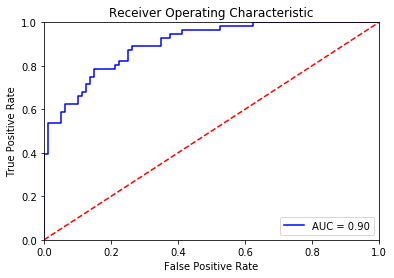

In [24]:
vec = TfidfVectorizer()
clf = MultinomialNB()
pipe = make_pipeline(vec, clf)
pipe.fit([r[0] for r in childhood_train], [r[1] for r in childhood_train])

predictions = pipe.predict([r[0] for r in childhood_test])
predicted_probabilities = pipe.predict_proba([r[0] for r in childhood_test])

performance(predictions, [e[1] for e in childhood_test])
roc_curve(predicted_probabilities, [e[1] for e in childhood_test])

### Logistic Regression

/home/damian/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy: 0.8823529411764706 
Recall (misinfo): 0.7321428571428571 
Precision (misinfo): 0.9761904761904762 
Recall (legitimate): 0.9875 
Precision (legitimate)  0.8404255319148937 
Confusion Matrix: 
 [[79  1]
 [15 41]]
ROC AUC:
0.9457589285714286


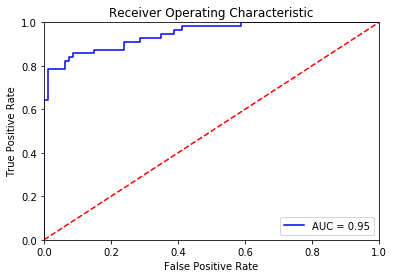

In [30]:
vec = TfidfVectorizer()
clf = LogisticRegression()
pipe = make_pipeline(vec, clf)
pipe.fit([r[0] for r in childhood_train], [r[1] for r in childhood_train])

predictions = pipe.predict([r[0] for r in childhood_test])
predicted_probabilities = pipe.predict_proba([r[0] for r in childhood_test])

performance(predictions, [e[1] for e in childhood_test])
roc_curve(predicted_probabilities, [e[1] for e in childhood_test])

### Logistic Regression with optimized cutoff point
(Spoiler: doesn't really change things)

In [23]:
fpr,tpr, thresholds = metrics.roc_curve([r[1] for r in childhood_test], predicted_probabilities[:,1], pos_label=1)
roc_auc = metrics.auc(fpr,tpr)
print("ROC AUC: {}".format(roc_auc))

optimal_threshold = get_optimal_threshold(fpr,tpr,thresholds)
print(optimal_threshold, np.exp(optimal_threshold))

predictions_new = np.where(predicted_probabilities[:,1] > optimal_threshold, 1, 0)

print('\n\nWITH THRESHOLD OF {}'.format(np.exp(optimal_threshold)))
performance(predictions_new, [e[1] for e in childhood_test])

ROC AUC: 0.9457589285714286
0.48126945003239435 1.618127230600975


WITH THRESHOLD OF 1.618127230600975
Accuracy: 0.8970588235294118 
Recall (misinfo): 0.7678571428571429 
Precision (misinfo): 0.9772727272727273 
Recall (legitimate): 0.9875 
Precision (legitimate)  0.8586956521739131 
Confusion Matrix: 
 [[79  1]
 [13 43]]


.... this doesn't really change anything.

## Feature Weights

Here, we use `eli5` to get a better idea of the features

In [11]:
eli5.show_weights(pipe,top=20)

Weight?,Feature
+0.929,dr
+0.805,we
+0.777,vaccinatieschade
+0.742,immuunsysteem
+0.693,vaccins
+0.674,aluminium
+0.673,http
+0.672,bijsluiter
+0.660,www
+0.653,vaccin


In [12]:
eli5.show_prediction(clf, hpv_test[2][0],vec=vec)

## Out of sample prediction

Accuracy: 0.797979797979798 
Recall (misinfo): 0.4393939393939394 
Precision (misinfo): 0.90625 
Recall (legitimate): 0.9772727272727273 
Precision (legitimate)  0.7771084337349398 
Confusion Matrix: 
 [[129   3]
 [ 37  29]]
ROC AUC:
0.8869375573921028


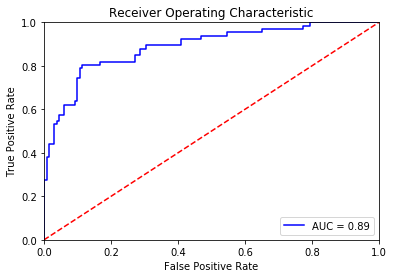

In [31]:

oos_predictions = pipe.predict([r[0] for r in hpv_test])
oos_predicted_probabilities = pipe.predict_proba([r[0] for r in hpv_test])


performance(oos_predictions, [e[1] for e in hpv_test])
roc_curve(oos_predicted_probabilities, [e[1] for e in hpv_test])

... but maybe here it's actually better if we used the adapted probabilities

In [39]:
oos_predictions_new = np.where(oos_predicted_probabilities[:,1] > optimal_threshold, 1, 0)

print('\n\nWITH THRESHOLD OF {}'.format(np.exp(optimal_threshold)))
performance(oos_predictions_new, [e[1] for e in hpv_test])



WITH THRESHOLD OF 1.618127230600975
Accuracy: 0.8181818181818182 
Recall (misinfo): 0.5151515151515151 
Precision (misinfo): 0.8947368421052632 
Recall (legitimate): 0.9696969696969697 
Precision (legitimate)  0.8 
Confusion Matrix: 
 [[128   4]
 [ 32  34]]


# oude scratch

In [ ]:
#Count_NB
#train & show performance
m1_nb = MultinomialNB()
m1_nb.fit(train_features_count, train_scores)
m1_predictions = m1_nb.predict(test_features_count)
performance(m1_predictions)
#%%
#Save
pk.dump(count_vectorizer,open('count_vectorizer.pkl',mode='wb'))
joblib.dump(m1_nb,'nb_classifier_count.pkl')
#%%
#tf-idf_NB
m2_nb = MultinomialNB()
m2_nb.fit(train_features_tfidf, train_scores)
m2_predictions = m2_nb.predict(test_features_tfidf)
performance(m2_predictions)
#%%
pk.dump(tfidf_vectorizer,open('tfidf_vectorizer.pkl',mode='wb'))
joblib.dump(m2_nb,'nb_classifier_tfidf.pkl')
#%%
#Count_LR
m3_logreg = LogisticRegression()
m3_logreg.fit(train_features_count, train_scores)
m3_predictions = m3_logreg.predict(test_features_count)
performance(m3_predictions)
#%%
joblib.dump(m3_logreg, 'logreg_classifier.pkl')
#%%
#tf-idf_LR
m4_logreg = LogisticRegression()
m4_logreg.fit(train_features_tfidf, train_scores)
m4_predictions = m4_logreg.predict(test_features_tfidf)
performance(m4_predictions)
#%%
joblib.dump(m4_logreg, 'logreg_classifier_tfidf.pkl')
#%%
#make ROCs
m1_predict_probabilities = m1_nb.predict_proba(test_features_count)
fpr, tpr, thresholds = metrics.roc_curve(actual_scores, m1_predict_probabilities[:,1],pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
print("ROC AUC:\n{}".format(roc_auc))
#%%
m2_predict_probabilities = m2_nb.predict_proba(test_features_tfidf)
fpr, tpr, thresholds = metrics.roc_curve(actual_scores, m2_predict_probabilities[:,1],pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
print("ROC AUC:\n{}".format(roc_auc))
#%%
m3_predict_probabilities = m3_logreg.predict_proba(test_features_count)
fpr, tpr, thresholds = metrics.roc_curve(actual_scores, m3_predict_probabilities[:,1],pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
print("ROC AUC:\n{}".format(roc_auc))
#%%